MIT License

Copyright (c) 2024 Sebastian Stein

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
!pip install --upgrade pip
!pip install --upgrade arviz watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1


In [ ]:
import arviz as az
import numpy as np

import matplotlib.pyplot as plt

import pymc as pm
# compile gradient function - need access to raw JAX function to do batching before compilation
# compile_pymc now lives in pytensorf
# https://github.com/pymc-devs/pymc/blob/main/pymc/pytensorf.py
# compilation done by pytensor.function(...)
# this is an alias for pytensor.compile.function.function()
from pymc.initial_point import compile_pymc # compile gradient function
from pymc.util import dataset_to_point_list # create batches of size 1

%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Mar 14 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

matplotlib: 3.7.1
pymc      : 5.10.4
numpy     : 1.25.2
arviz     : 0.17.1

Watermark: 2.4.3



argmax_x f(x): 0.34 with f(x) 0.33


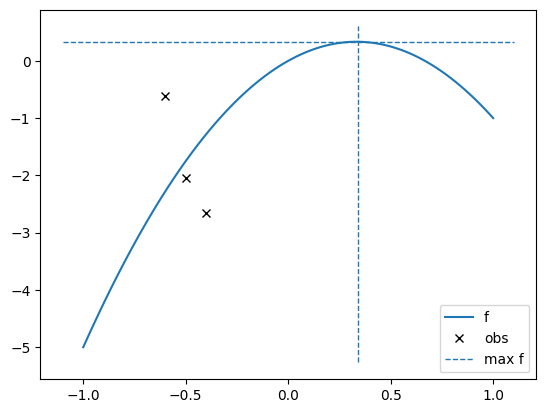

In [ ]:
# SEED
np_rng = np.random.default_rng(seed=123)

# define process and generate some noisy data
def process(x, a=-3, b=2):
  # underlying parametric function
  f = a*x**2 + b*x
  # additive noise
  y = f + np_rng.normal(size=f.shape)
  # return function values and noisy realisations
  return f, y

# characterize process
x_all = np.linspace(-1,1, 101)
f_all, y_all = process(x_all)

# sample data around one location
x_obs = np.array([-0.6, -0.5, -0.4])
_, y_obs = process(x_obs)

# plot function and data
p_all = plt.plot(x_all, f_all, label='f')
plt.plot(x_obs, y_obs, 'kx', label='obs')
plt.legend()

# plot optimum input and function value
f_max = f_all.max()
x_max = x_all[np.argmax(f_all)]
plt.plot([x_max]*2, plt.ylim(), '--', c=p_all[0].get_color(), linewidth=1)
plt.plot(plt.xlim(), [f_max]*2, '--', c=p_all[0].get_color(), linewidth=1, label='max f')
plt.legend()
print(f'argmax_x f(x): {x_max:.2} with f(x) {f_max:.2}')


In [ ]:
# some utilities; you can skip reading this

# plot quantiles of MCMC samples over x
def plot_posterior(x, y_samples, ax=None, label=''):
  if ax is None:
    fig, ax = plt.subplots()

  q = np.quantile(y_samples, q=[0.5, 0.025, 0.975, 0.25, 0.75], axis=-1).squeeze()
  a = ax.plot(x, q[0], label=f'{label} median')
  ax.fill_between(x, q[3], q[4], alpha=0.5, label=f'{label} 50% CI', color=a[0].get_color())
  ax.fill_between(x, q[1], q[2], alpha=0.2, label=f'{label} 95% CI', color=a[0].get_color())

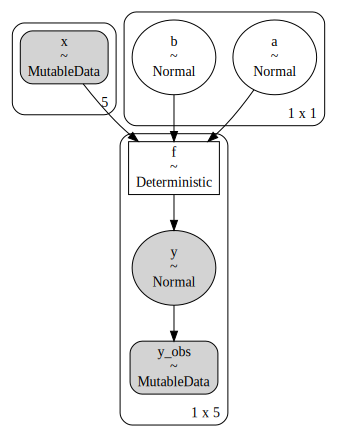

In [ ]:
# define the model of the forward process
# note: working with named dims makes it hard to change shapes later
def get_model(x_obs, y_obs, batch_size=1):

  model = pm.Model()
  with model:

    # data
    x = pm.Data('x', x_obs, mutable=True)
    y_obs = pm.Data('y_obs', y_obs, mutable=True)

    # prior
    #shape = None if batch_size <= 1 else (batch_size,1)
    shape = (batch_size,1)
    a = pm.Normal('a', mu=0, sigma=1, shape=shape)
    b = pm.Normal('b', mu=0, sigma=1, shape=shape)

    # likelihood
    f = pm.Deterministic('f', a*x**2 + b*x) # noise free function value
    y = pm.Normal('y', mu=f, sigma=0.2, observed=y_obs) # noisy realisation

  return model

model = get_model(x_obs, y_obs[None,:], batch_size=1)
pm.model_to_graphviz(model)

In [ ]:
# agent implementation
from pymc.model import modelcontext

# initialise agent:
class NoisyExpectedImprovement():

  def __init__(self,
               bounds,
               batch_size,
               model_opt,
               model_inf=None,
               f_name='f',
               x_name='x'):
    self.bounds = bounds # lower and upper bounds for x
    self.f_name = f_name # name of model RV representing f
    self.x_name = x_name # name of tensor representing x

    self.batch_size = batch_size
    self.model_opt = model_opt # model with batch_size in leading parameter dimension
    self.model_inf = model_inf # fetch model from context or param

    self.value_grad_fn = None # acquisition function and gradient
    self.posterior = None # keep last posterior sample
    self.vx = None # keep last trace of x in optimisation
    self.vei = None # keep last trace of expected improvement in optimisation
    self.vdx = None # keep last trace of gradients in optimisation

    self.attach_noisyEI() # extend model

  def attach_noisyEI(self, leak=0.01):
    # extend model with expected improvement objective
    for model in [self.model_inf, self.model_opt]:

      with model:
        best_f = pm.MutableData('best_f', 0)
        difference = model[self.f_name]-best_f
        # max(x, 0) has zero gradient where density > best_f is zero. Make leaky!
        improvement = pm.math.maximum(difference, leak * difference)
        # expectations over mcmc samples in batch
        neis = pm.Deterministic('nEI', improvement.mean(axis=0))
        # Cost must be a scalar
        sum_ni = pm.math.sum(neis)

        # compile function that computes nEI value and gradient
        dni = pm.pytensorf.gradient(sum_ni, vars=[model[self.x_name]])
        inputs = [model[v.name] for v in model.value_vars]
        self.value_grad_fn = compile_pymc(inputs=inputs, outputs=[sum_ni, dni])

  def step(self,
           x_obs,
           y_obs,
           lr=0.001,
           ax_posterior=None,
           ax_acquisition = None,
           n_steps=None):

    pm.set_data({'x': x_obs, 'y_obs': y_obs}, model=self.model_inf)
    self.posterior = pm.sample(model=self.model_inf)
    best_f, best_i = self.best_f()
    pm.set_data({'best_f': best_f}, model=self.model_inf)

    pm.set_data({'best_f': best_f}, model=self.model_opt)
    # prepare creation of batches of MCMC samples
    samples = az.extract(self.posterior, group='posterior')
    n_samples = samples[self.model_inf.value_vars[0].name].values.shape[-1]
    n_steps = n_samples if n_steps is None else n_steps

    # seed optimisation with best solution so far
    # TODO: implement multiple restarts for non-convex functions f
    x = np.ones(shape=(1,)) * x_obs[best_i]
    vx = [x.copy()]
    vei = []
    vdx = []
    for _ in range(n_steps):
      batch_idx = np_rng.choice(np.arange(n_samples), size=batch_size)
      batch = {}
      for v in model.value_vars:
        batch[v.name] = samples[v.name].values[:,:,batch_idx].reshape((batch_size,1))

      pm.set_data({'x': x}, model=self.model_opt)
      ei, dx = self.value_grad_fn(**batch)
      x += lr * dx
      x = np.clip(x, self.bounds[0], self.bounds[1])
      vx.append(x.copy())
      vei.append(ei.copy())
      vdx.append(dx.copy())

    self.vx = vx
    self.vei = vei
    self.vdx = vdx
    return vx[-1]

  def best_f(self):
    # compute the maximum expected value of f across training samples
    # return maximum value and index
    mean_posterior_f = az.extract(self.posterior)[self.f_name].values.mean(axis=-1).squeeze() # average across MCMC samples
    best_i = np.argmax(mean_posterior_f)
    return mean_posterior_f[best_i], best_i

  def predict(self, x_pred, x_name='x', var_names=['f']):
    with self.model_inf:
      # compute posterior predictive on new data
      pm.set_data({x_name: x_pred})
      predictive = pm.sample_posterior_predictive(self.posterior, var_names=var_names)

    return az.extract(predictive, group='posterior_predictive')

In [ ]:
def plot_fit(bo, x_all, f_all, x_obs, y_obs):

  best_f, best_i = bo.best_f()
  best_x = x_obs[best_i]
  print(f'f*: {best_f:.2} at x: {best_x:.2}')

  predictive = bo.predict(x_all, var_names=['f', 'nEI'])

  fig, axes = plt.subplots(2, 1, figsize=(12, 8))

  ax = axes[0]

  # plot true function and its maximum value
  ax.plot(x_all, f_all, 'r', label='f true')
  ax.plot([x_all[0] , x_all[-1]], [f_all.max()]*2, 'r--', linewidth=1, label='true max f')

  # plot estimated function and its maximum value amongst training samples
  plot_posterior(x_all, predictive.f.values, ax=ax, label='$\hat{f}$')
  ax.plot([x_all[0] , x_all[-1]], [best_f]*2, 'k--', linewidth=1, label='best $\hat{f}$')

  # plot data
  ax.plot(x_obs, y_obs, 'kx', label='data')

  # plots that depend on axis limits
  ylim = ax.get_ylim()
  ax.plot([x_all[np.argmax(f_all)]]*2, [ylim[0], f_all.max()], 'r--', alpha=0.5)
  ax.plot([best_x]*2, [ylim[0], best_f], 'k--', alpha=0.5)

  ax.set_xlabel('x')
  ax.set_ylabel('f(x)')
  ax.set_title('Bayesian inference')
  ax.legend()

  ax = axes[1]
  ax.plot(x_all, predictive.nEI.values.mean(axis=-1).squeeze())
  ax.set_title('Expected Improvement')
  ax.set_xlabel('x')
  ax.set_ylabel('Expected Improvement (EI)')

  fig.tight_layout()

In [ ]:
batch_size = 32
x_obs = x_obs[:3]
y_obs = y_obs[:3]
model_inf = get_model(x_obs, y_obs[None,:], batch_size=1)
model_opt = get_model(x_obs, y_obs[None,:], batch_size=batch_size)
bo = NoisyExpectedImprovement(bounds=[-1,1],
                              batch_size=batch_size,
                              model_inf=model_inf,
                              model_opt=model_opt)

In [ ]:
# find x that maximises acquisition function
x_next = bo.step(x_obs, y_obs[None,:], lr=0.1, n_steps=int(2000/batch_size))
print('suggested next design point', x_next)

suggested next design point [0.28710898]


f*: -1.0 at x: -0.4


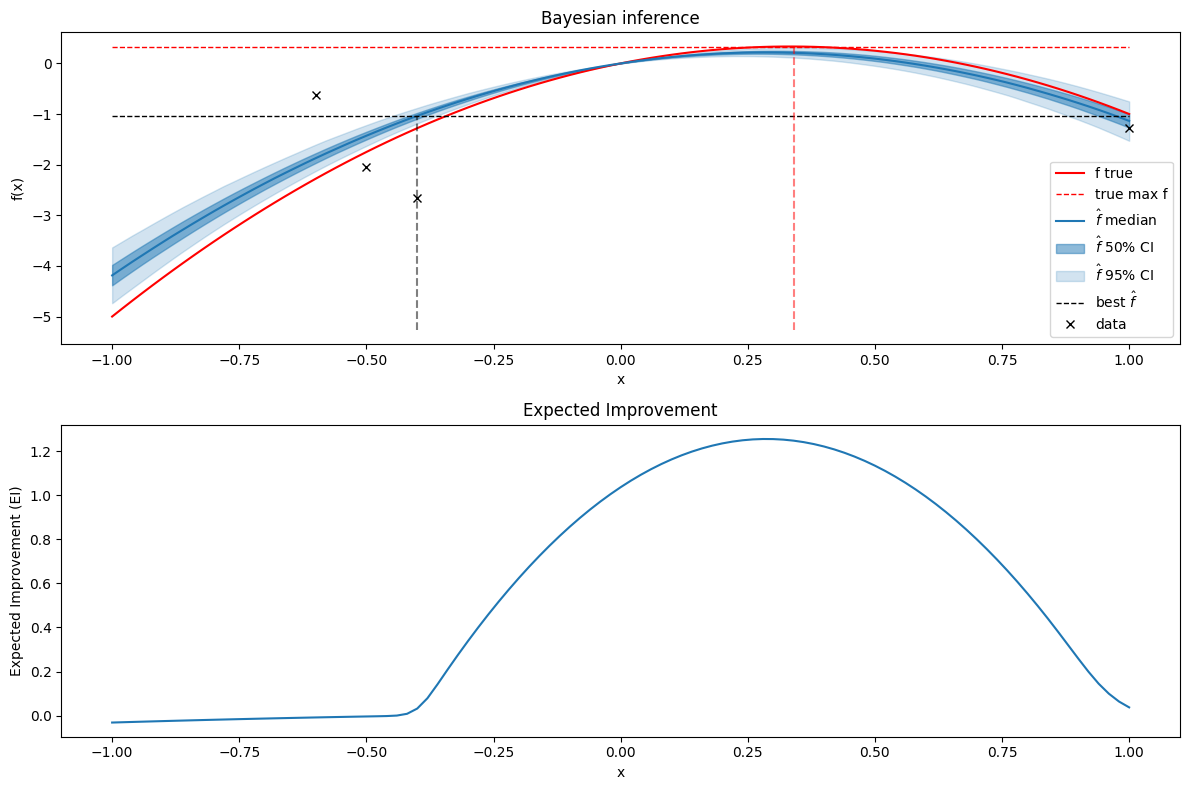

In [ ]:
plot_fit(bo, x_all, f_all, x_obs, y_obs)

# run experiment "in the real world"
x_obs = np.hstack((x_obs, x_next))
y_obs = np.hstack((y_obs, process(x_next)[1] ))

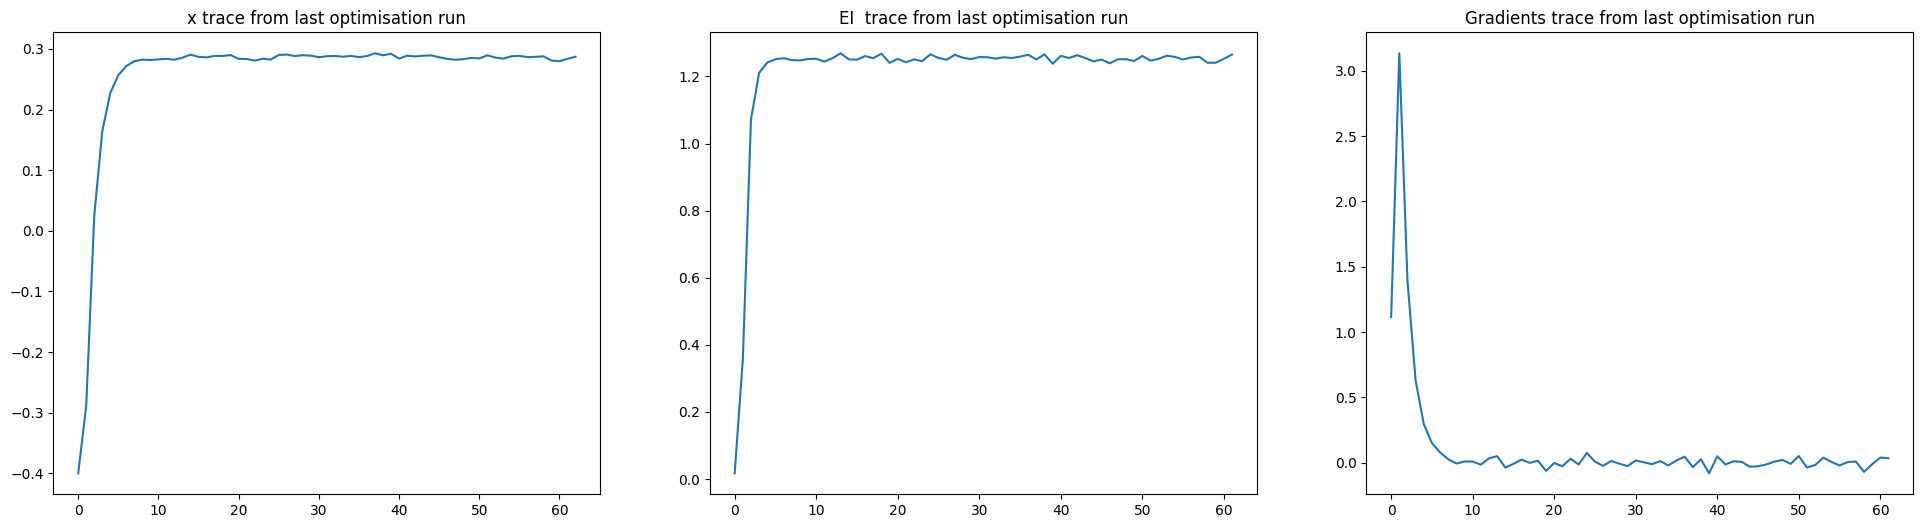

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(3*8, 6))
axes[0].plot(bo.vx)
axes[0].set_title('x trace from last optimisation run');
axes[1].plot(bo.vei)
axes[1].set_title('EI  trace from last optimisation run');
axes[2].plot(bo.vdx)
axes[2].set_title('Gradients trace from last optimisation run');